In [2]:
import pandas as pd
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Concatenate

nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('indonesian'))


c:\Users\acer\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\acer\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\acer\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/

In [3]:
# Baca CSV hasil scraping YouTube
df = pd.read_csv("youtube_judi_all_comments.csv")

# Contoh dataset (komentar, label)
print(df.head())


      video_id                                            comment  label
0  uxnScsdLZds  Podcast nya cuma modal bacot tp gak di praktek...    NaN
1  uxnScsdLZds  Negara negara maju yg punya rumah judi lebih d...    NaN
2  uxnScsdLZds  Mending main ke casino langsung.......ngapain ...    NaN
3  uxnScsdLZds  Sebenrnya bola bisa kok. Main bola jalan aja  ...    NaN
4  uxnScsdLZds                       Menikmati hasil yutup doang🗿    NaN


In [4]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # hapus URL
    text = re.sub(r"[^a-zA-Z0-9\s]", '', text)          # hapus simbol
    text = re.sub(r"\d+", '', text)                     # hapus angka
    text = ' '.join([word for word in text.split() if word not in stop_words])  # hapus stopword
    return text

df['clean_comment'] = df['comment'].astype(str).apply(clean_text)

print(df[['comment','clean_comment']].head())


                                             comment  \
0  Podcast nya cuma modal bacot tp gak di praktek...   
1  Negara negara maju yg punya rumah judi lebih d...   
2  Mending main ke casino langsung.......ngapain ...   
3  Sebenrnya bola bisa kok. Main bola jalan aja  ...   
4                       Menikmati hasil yutup doang🗿   

                                       clean_comment  
0  podcast nya modal bacot tp gak praktekkan lang...  
1  negara negara maju yg rumah judi bikin undang ...  
2  mending main casino langsungngapain judoljudol...  
3    sebenrnya bola main bola jalan aja profit hahaa  
4                        menikmati hasil yutup doang  


In [5]:
# Label harus kamu isi manual dulu di CSV (positif/negatif/netral)
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])
y = to_categorical(df['label_enc'])


In [6]:
MAX_NUM_WORDS = 10000
MAX_SEQ_LEN = 100
EMB_DIM = 128

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_comment'])
X = tokenizer.texts_to_sequences(df['clean_comment'])
X = pad_sequences(X, maxlen=MAX_SEQ_LEN, padding='post')

print("Jumlah data:", X.shape, y.shape)


Jumlah data: (870, 100) (870, 1)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [8]:
def build_textcnn(max_seq_len, max_num_words, emb_dim, num_classes):
    inputs = Input(shape=(max_seq_len,))
    embedding = Embedding(max_num_words, emb_dim, input_length=max_seq_len)(inputs)

    convs = []
    filter_sizes = [3,4,5]
    for fsz in filter_sizes:
        conv = Conv1D(filters=128, kernel_size=fsz, activation='relu')(embedding)
        pool = GlobalMaxPooling1D()(conv)
        convs.append(pool)

    merged = Concatenate()(convs)
    dropout = Dropout(0.5)(merged)
    outputs = Dense(num_classes, activation='softmax')(dropout)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

num_classes = y.shape[1]
model = build_textcnn(MAX_SEQ_LEN, MAX_NUM_WORDS, EMB_DIM, num_classes)
model.summary()


c:\Users\acer\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 128)  │  1,280,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 98, 128)   │     49,280 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 97, 128)   │     65,664 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 96, 128)   │     82,048 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 384)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │        385 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,477,377 (5.64 MB)

 Trainable params: 1,477,377 (5.64 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/10


c:\Users\acer\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\ops\nn.py:938: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
c:\Users\acer\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\losses\losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 1.

In [10]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Akurasi Test: {acc*100:.2f}%")


Akurasi Test: 100.00%


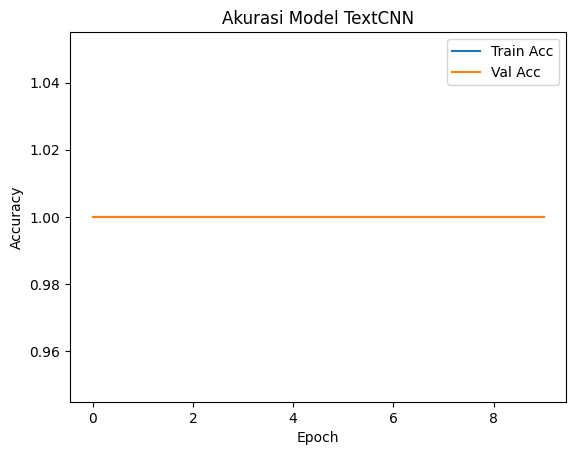

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Akurasi Model TextCNN")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
